In [ ]:
# Imports

In [2]:
%%time
import os
import time
import numpy
import pickle
import cProfile
import itertools
import matplotlib
matplotlib.use('Agg')
from sklearn import metrics 
from sklearn.svm import SVC
from sklearn.feature_selection import *
from sklearn.svm import LinearSVC
from matplotlib import pyplot as plt
from sklearn import cross_validation
from sklearn.linear_model import *
from sklearn.metrics import *
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.kernel_approximation import *
from sklearn.preprocessing import StandardScaler
from sklearn.learning_curve import learning_curve
from sklearn.model_selection import *
from sklearn.cross_validation import cross_val_score
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.cross_validation import train_test_split
from sklearn.feature_selection import mutual_info_classif

# %jsroot on9
%matplotlib inline

CPU times: user 950 ms, sys: 138 ms, total: 1.09 s
Wall time: 1.48 s


/usr/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [3]:
# %%time
# tChain = rt.TChain('MyAnalysis/MyTree')
# tChain.Add("ntuples/*.root")
# array = root_numpy.tree2array(tChain)
# print 'Total number of entries: ',tChain.GetEntries()


# Function Definitions

In [4]:
#%%time
def outputs(array):
    goodEvents = array[array['lumi'] != 0]
    ind = numpy.lexsort((goodEvents['lumiId'],goodEvents['runId']))
    events = goodEvents[ind]
    dataset = numpy.empty([len(goodEvents),30])
    target = numpy.empty([len(goodEvents)])
    badOnes = numpy.array([])

    for j, event in enumerate(events):
        try:
            dataset[j,0:7] = event['qPFJetPt']
            dataset[j,7:14] = event['qPFJetEta']
            dataset[j,14:21] = event['qPFJetPhi']
            dataset[j,21:28] = event['qNVtx']
            dataset[j,28] = event['crossSection']
            dataset[j,29] = event['lumi']
            target[j] = event['isSig']
        except ValueError:
            badOnes = numpy.append(badOnes,j)
            
    mask = numpy.zeros(len(dataset), dtype=bool)
    mask[badOnes.astype(int)] = True
    mask = ~mask
    dataset = dataset[mask]
    target = target[mask]
       
    return dataset, target

In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = numpy.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
        print("Normalized confusion matrix")
    else:
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = numpy.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max()*.7
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Settings and Data Prep

In [3]:
# %%time
#Pick learning algorithm, crossSection, weights, and random splitting
SVM = True
BDT = True
crossSection = True
weights = False
random = True
odds = False

# dataset, target = outputs(array)
# outFile = open('data.pkl', 'wb')
# pickle.dump(dataset, outFile)
# pickle.dump(target, outFile)
# outFile.close()

inFile = open('realData.pkl', 'rb')
dataset = pickle.load(inFile, encoding="latin1")
target = pickle.load(inFile, encoding="latin1")
inFile.close()

In [6]:
# #%%time
# #Splits the data into training and testing sets
# xTrain = []
# yTrain = []
# xTest = []
# yTest = []

# if random == True:
#     xTrain, xTest, yTrain, yTest = train_test_split(dataset, target, test_size=0.5)

#     lumiTrain = xTrain[:,-1]
#     lumiTest = xTest[:,-1]
#     lumiTrain = numpy.copy(lumiTrain, order='C')
#     lumiTest = numpy.copy(lumiTest, order='C')

#     if crossSection == True:
#         xTrain = xTrain[:,:-1]
#         xTest = xTest[:,:-1]
#     else:
#         xTrain = xTrain[:,:-2]
#         xTest = xTest[:,:-2]
# elif odds == True:
#     lumiTrain = dataset[::2,-1]
#     lumiTest = dataset[1::2,-1]
#     lumiTrain = numpy.copy(lumiTrain, order='C')
#     lumiTest = numpy.copy(lumiTest, order='C')
    
#     xTrain = dataset[::2]
#     xTest = dataset[1::2]
#     yTrain = target[::2]
#     yTest = target[1::2]
# else:  
#     n = int(numpy.floor(len(dataset)/2))
#     lumiTrain = dataset[:n,-1]
#     lumiTest = dataset[n:,-1]
#     lumiTrain = numpy.copy(lumiTrain, order='C')
#     lumiTest = numpy.copy(lumiTest, order='C')
    
#     if crossSection ==  True:
#         xTrain = dataset[:n,:-1]
#         xTest = dataset[n:,:-1]
#     else:
#         xTrain = dataset[:n,:-2]
#         xTest = dataset[n:,:-2]
        
#     yTrain = target[:n]
#     yTest = target[n:]

In [8]:
inFile = open('splits.pkl', 'rb')
xTrain = pickle.load(inFile, encoding="latin1")
xTest = pickle.load(inFile, encoding="latin1")
yTrain = pickle.load(inFile, encoding="latin1")
yTest = pickle.load(inFile, encoding="latin1")
lumiTrain = pickle.load(inFile, encoding="latin1")
lumiTest = pickle.load(inFile, encoding="latin1")
inFile.close()

In [7]:
sel = VarianceThreshold(threshold = .01)
print(xTrain.shape)
sel.fit(xTrain)
indices = sel.get_support()
xTrain = xTrain[:,indices]
print(xTrain.shape)
xTest = xTest[:,indices]
print(indices)
# mask = numpy.ones(29,dtype=bool)
# print(mask)
# ind = [1, 2, 6, 7, 9, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21]
# mask[ind] = False
# print(mask)
# print(xTrain.shape)
# xTrain = xTrain[:,mask]
# print(xTrain.shape)
# xTest = xTest[:,mask]


NameError: name 'xTrain' is not defined

In [7]:
%%time
scaler = StandardScaler()
scaler.fit(xTrain)
xTrain = scaler.transform(xTrain)
xTest = scaler.transform(xTest)
# yTrain[yTrain == 0] = -1
# yTest[yTest == 0] = -1
# print(len(yTrain[yTrain==-1]))
# print(len(yTrain[yTrain==1]))

CPU times: user 39 ms, sys: 0 ns, total: 39 ms
Wall time: 38.6 ms


In [ ]:
# nIterations = numpy.ceil(10**6/len(xTrain))
# print(len(xTrain))

# # tunedParams = [{'loss': ['hinge','modified_huber','log'], 'penalty': ['l2', 'l1', 'elasticnet'], 
# #                 'alpha':[0.0001,0.1,1,1.5], 'n_iter':[nIterations, 100, 1000], 'class_weight':[None, 'balanced']}]
# tunedParams = [{'rbfFeat__gamma':[1,.5,.001,5,.7], 'rbfFeat__n_components': ['100,1000,50,10']}]
# scores = ['roc_auc'] #'f1'
# for score in scores:
#     print("# Tuning hyper-parameters for %s" % score)
#     print()

#     rbfFeature = RBFSampler()
#     clf  = SGDClassifier(loss='modified_huber', penalty = 'l2', shuffle = True, learning_rate = 'optimal',
#                          class_weight='balanced', n_iter=100, alpha = 0.0001, average=True, warm_start=True)

#     pipe = Pipeline([('rbfFeat',rbfFeature), ('sgd', clf)])
#     clf = GridSearchCV(pipe,tunedParams,n_jobs=1)
    
# #     clf = GridSearchCV(SGDClassifier(shuffle=True, average=True,warm_start=True,learning_rate='optimal'), 
# #                        tunedParams, scoring='%s' % score)
# #     pipe.rbfFeat.fit(xTrain)
# #     newXTrain = rbfFeat.transform(xTrain)
# #     newXTest = rbfFeat.transform(xTest)
#     clf.fit(xTrain, yTrain)
    
#     print("Best parameters set found on development set:")
#     print()
#     print(clf.best_params_)
#     print()
#     print("Grid scores on development set:")
#     print()
#     means = clf.cv_results_['mean_test_score']
#     stds = clf.cv_results_['std_test_score']
#     for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#         print("%0.3f (+/-%0.03f) for %r"
#               % (mean, std * 2, params))
#     print()

#     print("Detailed classification report:")
#     print()
#     print("The model is trained on the full development set.")
#     print("The scores are computed on the full evaluation set.")
#     print()
#     y_true, y_pred = yTest, clf.predict(xTest)
#     print(classification_report(y_true, y_pred))
#     print()

In [ ]:
# oneInd = numpy.where(yTest == 1)
# negInd = numpy.where(yTest == -1)
# testTest = numpy.copy(yTest)
# testTest[oneInd] = -1
# testTest[negInd] = 1


# Trains and Tests

In [13]:
%%time
# rbfFeature = RBFSampler(gamma = .17, n_components = 10000)
# rbfFeature.fit(xTrain)
# newXTrain = rbfFeature.transform(xTrain)
# newXTest = rbfFeature.transform(xTest)
# nysFeature = Nystroem(gamma = 1000, n_components = 1000)
# nysFeature.fit(xTrain)
# newXTrain = nysFeature.transform(xTrain)
# newXTest = nysFeature.transform(xTest)
sgdClf = SGDClassifier(loss='modified_huber', penalty = 'l2', shuffle = True, learning_rate = 'optimal',
                       class_weight='balanced', n_iter=100, alpha = 0.0001, average=True, warm_start=True)
sgdClf.fit(newXTrain,yTrain,sample_weight=lumiTrain)
print(sgdClf.score(newXTest,yTest))

0.948338911882
CPU times: user 1min 25s, sys: 148 ms, total: 1min 25s
Wall time: 1min 25s


In [ ]:
# outClfs = open('sgdClf_tuned_weights.pkl', 'wb')
# pickle.dump(sgdClf, outClfs)
# outClfs.close()

# # # # outClfs = open('svmClf_untuned_weights.pkl', 'rb')
# # # # svmClf = pickle.load(outClfs)
# # # # outClfs.close()

In [9]:
%%time
#Provides classification reports 
if weights == True:    
    sgdScore = sgdClf.fit(newXTrain, yTrain, sample_weight = lumiTrain).decision_function(newXTest)
else:
    sgdScore = sgdClf.fit(newXTrain, yTrain).decision_function(newXTest)

sgdPredict = sgdClf.predict(newXTest)
print("Classification report for SGD, Tuned, No Weights,  %s:\n%s\n"
      % (sgdClf, metrics.classification_report(yTest, sgdPredict)))
#{'penalty': 'l2', 'class_weight': 'balanced', 'alpha': 1, 'n_iter': 9.0, 'loss': 'hinge'}
#{'n_iter': 9.0, 'loss': 'log', 'penalty': 'l1', 'alpha': 0.1, 'class_weight': None}
#{'class_weight': 'balanced', 'n_iter': 1000, 'alpha': 0.0001, 'penalty': 'l2', 'loss': 'log'}


Classification report for SGD, Tuned, No Weights,  SGDClassifier(alpha=0.0001, average=True, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='modified_huber', n_iter=100,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, verbose=0, warm_start=True):
             precision    recall  f1-score   support

        0.0       0.05      1.00      0.10      6004
        1.0       0.00      0.00      0.00    110215

avg / total       0.00      0.05      0.01    116219


CPU times: user 1min 29s, sys: 64 ms, total: 1min 29s
Wall time: 1min 28s


/usr/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
# print(sgdPredict)
# oneInd = numpy.where(sgdPredict == 1)
# negInd = numpy.where(sgdPredict == -1)
# testPred = numpy.copy(yTest)
# testPred[oneInd] = -1
# testPred[negInd] = 1
# print(testPred)

In [ ]:
# outfile = open('sgd_classscores_tuned_weights.pkl', 'wb')
# pickle.dump(sgdScore, outfile)
# pickle.dump(sgdPredict, outfile)
# outfile.close()

# Plots classification results

In [10]:
%%time
# Total of four things: Training and Testing For signal and background (S and B)
sgdArrs = []
sgdHists = []

sgdArrs.append(sgdClf.decision_function(newXTrain[yTrain>0.5]).ravel())
sgdArrs.append(sgdClf.decision_function(newXTrain[yTrain<0.5]).ravel())
sgdArrs.append(sgdClf.decision_function(newXTest[yTest>0.5]).ravel())
sgdArrs.append(sgdClf.decision_function(newXTest[yTest<0.5]).ravel())
print(len(xTrain))
print(len(xTest))
print(len(sgdArrs[0]))
print(len(sgdArrs[1]))
print(len(sgdArrs[2]))
print(len(sgdArrs[3]))

sgdHists.append(list(numpy.histogram(sgdArrs[0], normed = True, bins = 40)))
sgdHists.append(list(numpy.histogram(sgdArrs[1], normed = True, bins = 40))) 
sgdHists.append(list(numpy.histogram(sgdArrs[2], normed = True, bins = 40)))
sgdHists.append(list(numpy.histogram(sgdArrs[3], normed = True, bins = 40)))

sgdMax = max([hist[0].max() for hist in sgdHists])*1.2
sgdMin = max([hist[0].min() for hist in sgdHists])
sgdEdges = sgdHists[0][1]
sgdCenters = (sgdEdges[:-1] + sgdEdges[1:])/2.
sgdWidths = (sgdEdges[1:] - sgdEdges[:-1])

116219
116219
110226
5993
110215
6004
CPU times: user 2.32 s, sys: 1.87 s, total: 4.18 s
Wall time: 3.3 s


In [ ]:
# outFile = open('testHistsNoRand.pkl', 'wb')
# pickle.dump(svmArrs, outFile)
# pickle.dump(svmHists, outFile)
# pickle.dump(bdtArrs, outFile)
# pickle.dump(bdtHists, outFile)
# outFile.close()

In [11]:
normValSig = max(max(sgdHists[0][0]), max(sgdHists[1][0]))
sgdHists[0][0] = [x/normValSig for x in sgdHists[0][0]]
sgdHists[1][0] = [x/normValSig for x in sgdHists[1][0]]
normValBack = max(max(sgdHists[2][0]), max(sgdHists[3][0]))
sgdHists[2][0] = [x/normValBack for x in sgdHists[2][0]]
sgdHists[3][0] = [x/normValBack for x in sgdHists[3][0]]

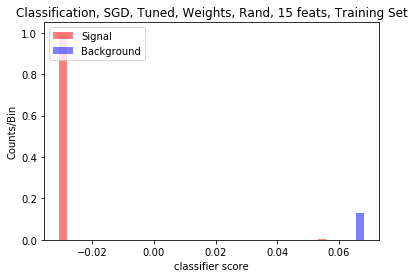

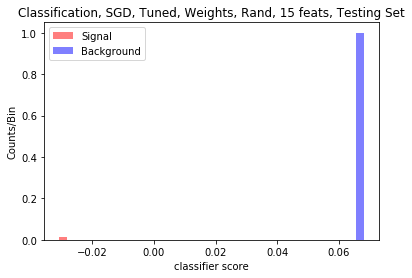

CPU times: user 811 ms, sys: 18 ms, total: 829 ms
Wall time: 835 ms


In [12]:
%%time
ax1 = plt.subplot(111)
ax1.bar(sgdCenters-sgdWidths/2.,sgdHists[0][0],facecolor='red',linewidth=0,width=sgdWidths,label='Signal',alpha=0.5)
ax1.bar(sgdCenters-sgdWidths/2.,sgdHists[1][0],facecolor='blue',linewidth=0,width=sgdWidths,label='Background',alpha=0.5)
#Change depending on which classifier and options are chosen
plt.title("Classification, SGD, Tuned, Weights, Rand, 15 feats, Training Set")
plt.xlabel("classifier score")
plt.ylabel("Counts/Bin")
legend = ax1.legend(loc='upper center', shadow=True,ncol=2)
for alabel in legend.get_texts():
            alabel.set_fontsize('small')
plt.legend(loc='upper left')

plt.show()

ax2 = plt.subplot(111)
ax2.bar(sgdCenters-sgdWidths/2.,sgdHists[2][0],facecolor='red',linewidth=0,width=sgdWidths,label='Signal',alpha=0.5)
ax2.bar(sgdCenters-sgdWidths/2.,sgdHists[3][0],facecolor='blue',linewidth=0,width=sgdWidths,label='Background',alpha=0.5)
plt.title("Classification, SGD, Tuned, Weights, Rand, 15 feats, Testing Set")
plt.xlabel("classifier score")
plt.ylabel("Counts/Bin")
legend = ax1.legend(loc='upper center', shadow=True,ncol=2)
for alabel in legend.get_texts():
            alabel.set_fontsize('small')
plt.legend(loc='upper left')
plt.show()

In [ ]:
# decs = sgdClf.decision_function(xTest)
# backs = decs[decs<-28]
# sigs = decs[decs>-15]
# #greys = decs[-28 <= decs and decs <= -15]
# #print(min(backs))
# print(min(sigs))
# #print(len(greys))
# sgdHists[0]

In [ ]:
%%time
fpr, tpr, _ = roc_curve(yTest, sgdScore)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2;
plt.plot(fpr, tpr, color='darkorange',
        lw = lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw = lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC SGD, Tuned, Weights, Rand')
plt.legend(loc="lower right")
plt.show()

In [ ]:
classNames = ['Background','Signal']
confMat = confusion_matrix(yTest, sgdPredict)
#numpy.set_printoptions(precision=)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(confMat, classes=classNames,
                      title='Confusion matrix, SGD, Tuned, Un-normalization, No Weights')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(confMat, classes=classNames, normalize=True,
                      title='Confusion Matrix, SGD, Tuned, Normalized, No Weights')

plt.show()

In [ ]:
matthews_corrcoef(yTest,sgdPredict)

In [6]:
dataset = dataset[:,:-1]
sigInd = numpy.where(target==1)
backInd = numpy.where(target==0)
sigVals = dataset[sigInd]
backVals = dataset[backInd]
sigTarget = target[sigInd]
backTarget = target[backInd]
print((dataset[i][7]))

[  3.87361717e+01   4.99334755e+01   1.00006313e+01   1.18214235e+01
   1.56189651e+01   4.22247925e+01   6.35977844e+02  -4.67636697e-02
   2.24842644e+00  -4.99994993e+00  -2.03123927e+00  -4.93688174e-02
   1.89219439e+00   4.98895407e+00  -2.07334254e-02   1.82496822e+00
  -3.14147949e+00  -1.60498607e+00  -2.07236391e-02   1.54816425e+00
   3.14140129e+00   1.80000000e+01   4.00000000e+00   8.00000000e+00
   1.50000000e+01   1.80000000e+01   2.10000000e+01]


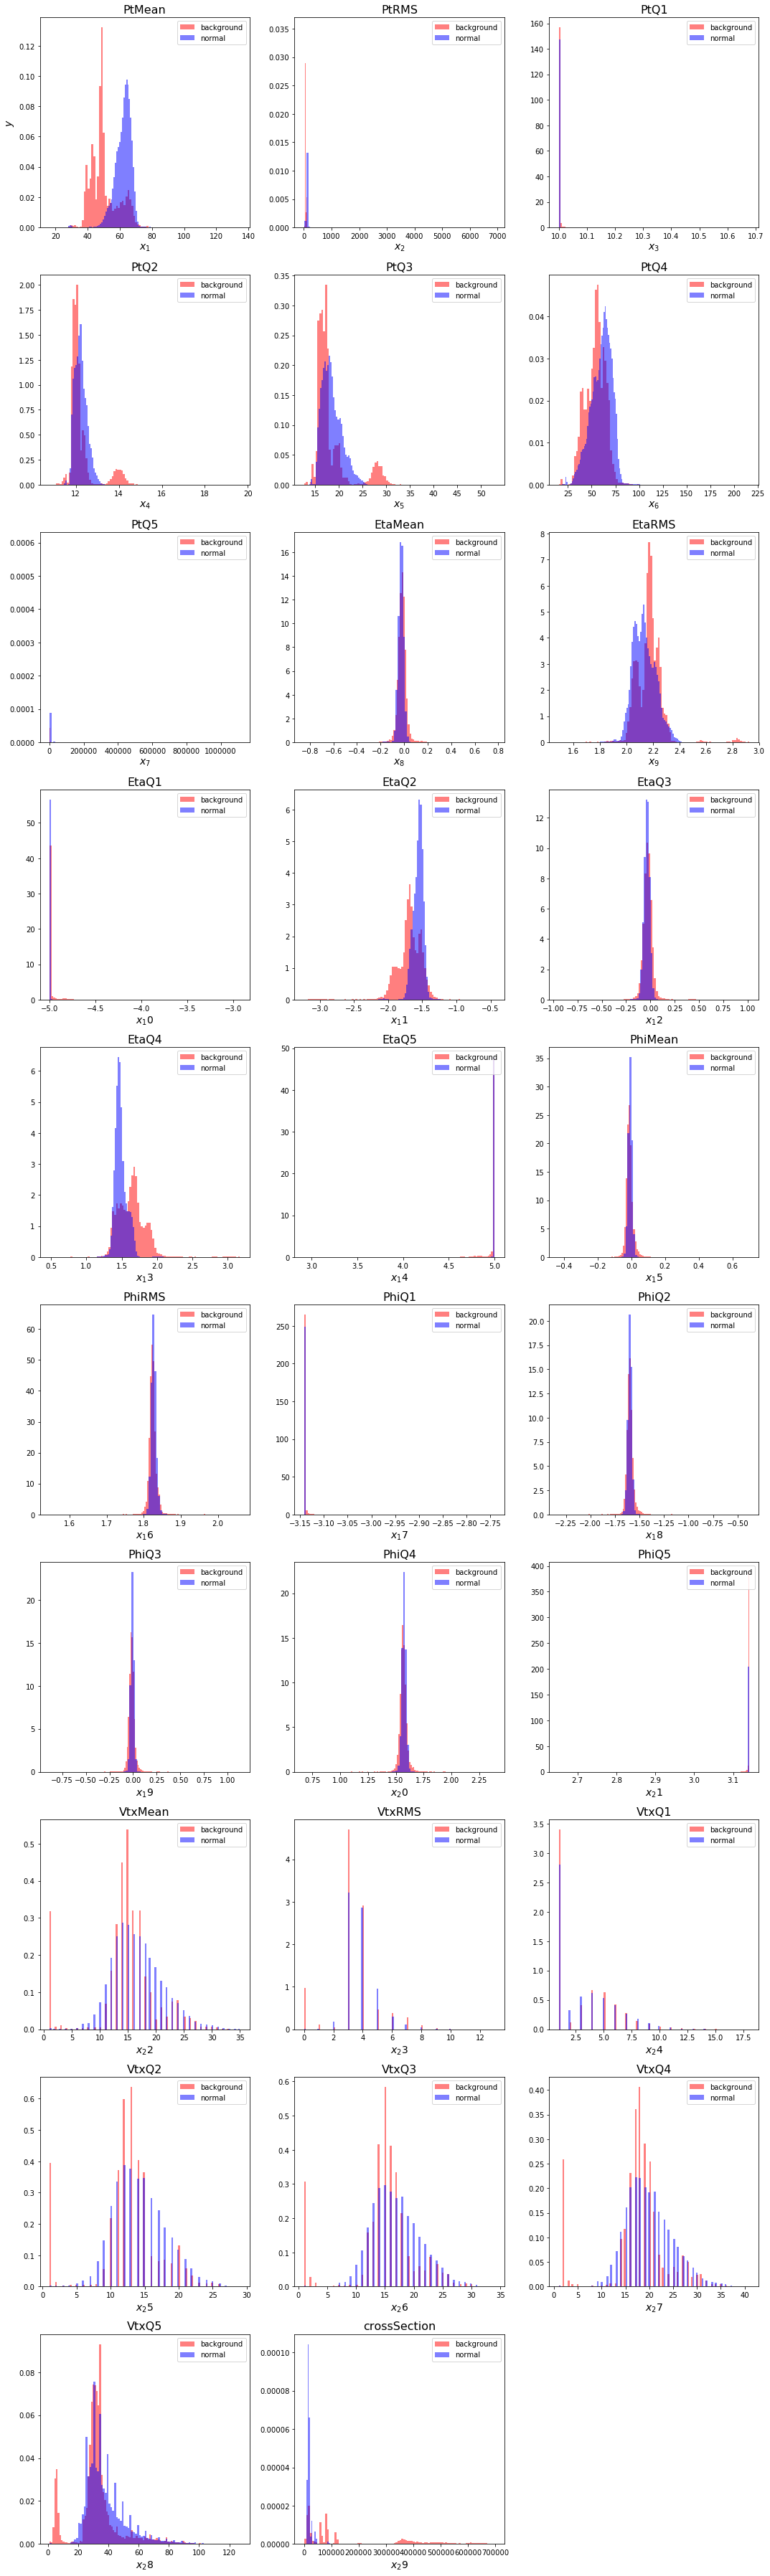

In [13]:
labels = ['PtMean','PtRMS','PtQ1','PtQ2','PtQ3','PtQ4','PtQ5',
           'EtaMean','EtaRMS','EtaQ1','EtaQ2','EtaQ3','EtaQ4','EtaQ5',
           'PhiMean','PhiRMS','PhiQ1','PhiQ2','PhiQ3','PhiQ4','PhiQ5',
           'VtxMean','VtxRMS','VtxQ1','VtxQ2','VtxQ3','VtxQ4','VtxQ5', 'crossSection']

fig = plt.figure(figsize=(15, 50))
for i in range(29):
    plt.subplot(10, 3, i + 1)
    plt.hist(backVals[:,i], 100, facecolor='red', alpha=0.5, label="background", normed = True)
    plt.hist(sigVals[:,i], 100, facecolor='blue', alpha=0.5, label="normal", normed = True)
    plt.legend(loc="upper right")
    
    plt.xlabel("$x_{}$".format(i + 1), fontsize=14)
    
    if i == 0:
        plt.ylabel("$y$", fontsize=14)
    plt.title(labels[i],fontsize=16)
plt.tight_layout()
# plt.show()
# savefig('/afs/cern.ch/user/f/fsiroky/Desktop/Humza_analysis/foo.png')
plt.savefig('/afs/cern.ch/user/f/fsiroky/Desktop/Humza_analysis/feature_plots.pdf', dpi=fig.dpi)

In [17]:
for i in range(29):
    print(numpy.max(xTrain[:,i]))
sel.variances_

134.734115601
6895.12255859
10.4197435379
18.0006313324
52.8546028137
215.863555908
1112052.75
0.634671449661
2.92720985413
-2.92564129829
-0.439793258905
1.01762592793
3.17519783974
4.99999952316
0.700900316238
1.99087107182
-2.77892899513
-0.380055993795
1.13172352314
2.2613735199
3.14159274101
35.0
12.0
16.0
29.0
34.0
41.0
123.0
697666.6875


array([  3.61951712e+01,   1.04738232e+03,   2.25945847e-05,
         1.07644424e-01,   5.30851632e+00,   1.20976929e+02,
         3.04942378e+07,   7.71888442e-04,   7.60179895e-03,
         8.55899976e-04,   8.81568889e-03,   1.19319248e-03,
         1.05122916e-02,   1.46510576e-03,   1.80999995e-04,
         5.19796952e-05,   1.14093929e-05,   5.36993641e-04,
         4.23640594e-04,   4.58632112e-04,   1.47528391e-05,
         2.07527401e+01,   1.12807192e+00,   6.15510896e+00,
         1.55260114e+01,   1.95589896e+01,   2.50849952e+01,
         1.89858884e+02,   3.45860831e+09])

In [18]:
t = numpy.append
for i in range(29):
    print(numpy.var(xTrain[:,i]))

36.1951711998
1047.38232035
2.25945847115e-05
0.107644424113
5.30851632003
120.976928994
30494237.8262
0.000771888442377
0.00760179894712
0.000855899976396
0.00881568888619
0.00119319248204
0.0105122916087
0.00146510576093
0.000180999995366
5.19796951916e-05
1.14093929183e-05
0.000536993641343
0.000423640593734
0.000458632111763
1.47528390758e-05
20.7527401202
1.12807191651
6.15510895934
15.5260113971
19.5589895848
25.0849951712
189.85888356
3458608307.4


In [19]:
numpy.var(xTrain[:,i])

3458608307.4012775

In [20]:
q = numpy.array([4,5,1,7,4,7])
numpy.argmax(q)

3